---

# **Sketch 2 Image Generator**
## A deep learning model that generates realistic images of birds from hand drawn sketches. 
## GitHub Repository: [Image Generator](https://github.com/EgeEken/Image-Generator)
### - Libraries: **PyTorch**, **OpenCV**, **NumPy**
### - MLOps: **Docker**, **MLflow**
### - GUI: **Gradio**
### - Dataset: [Kaggle Bird Dataset](https://www.kaggle.com/datasets/vinjamuripavan/bird-species)

---

In [43]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129
   ---------------------------------------- 0.0/3.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 GB 10.5 MB/s eta 0:05:42
   ---------------------------------------- 0.0/3.6 GB 8.2 MB/s eta 0:07:15
   ---------------------------------------- 0.0/3.6 GB 7.7 MB/s eta 0:07:41
   ---------------------------------------- 0.0/3.6 GB 7.5 MB/s eta 0:07:56
   ---------------------------------------- 0.0/3.6 GB 7.3 MB/s eta 0:08:06
   ---------------------------------------- 0.0/3.6 GB 7.3 MB/s eta 0:08:12
   ---------------------------------------- 0.0/3.6 GB 7.2 MB/s eta 0:08:17
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:21
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:23
   ---------------------------------------- 0.0/3.6 GB 7.1 MB/s eta 0:08:25
   ---------------------------------------- 0.0/3.6 GB 7.0 MB/s eta 0:08:27
   --------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install opencv-python matplotlib mlflow gradio

  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/26.7 MB ? eta -:--:--
   ----- ---------------------------------- 3.4/26.7 MB 18.0 MB/s eta 0:00:02
   ------------ --------------------------- 8.7/26.7 MB 22.1 MB/s eta 0:00:01
   ---------------------------- ----------- 18.9/26.7 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------  26.5/26.7 MB 34.3 MB/s eta 0:00:01
   ---------------------------------------- 26.7/26.7 MB 32.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Core
import os
from pathlib import Path
import random
import time

# Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# PyTorch
import torch
print(torch.__version__)
print(torch.cuda.is_available())
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Optional: MLflow
import mlflow


2.8.0+cu129
True


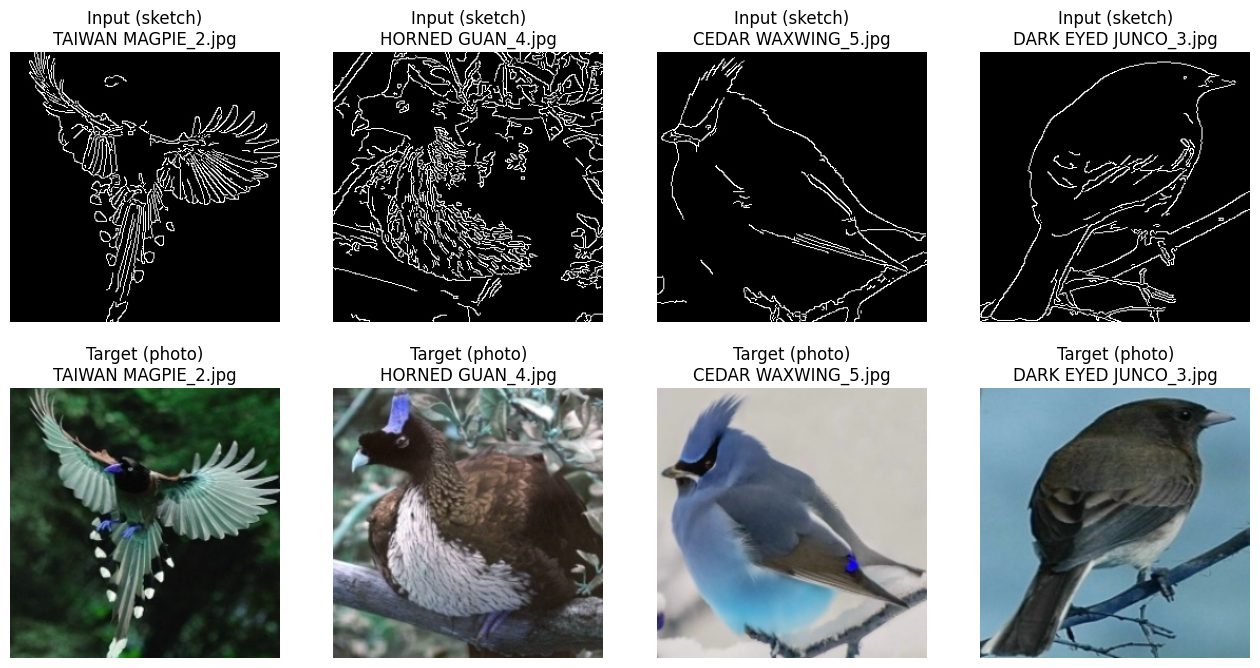

In [5]:
class Sketch2ImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, image_size=(256,256)):
        self.inputs = sorted(list(Path(input_dir).glob("*.jpg")))
        self.targets = sorted(list(Path(target_dir).glob("*.jpg")))
        self.image_size = image_size
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_img = cv2.imread(str(self.inputs[idx]), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.imread(str(self.targets[idx]))

        input_img = cv2.resize(input_img, self.image_size)
        target_img = cv2.resize(target_img, self.image_size)

        # Normalize 0-1 and convert to tensors
        input_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0)  # 1xHxW
        target_img = torch.tensor(target_img/255.0, dtype=torch.float32).permute(2,0,1)  # 3xHxW
        return input_img, target_img, str(self.inputs[idx].name)

# Example usage:
train_dataset = Sketch2ImageDataset(
    "../data_prepared/train/inputs",
    "../data_prepared/train/targets"
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Small validation set
val_dataset = Sketch2ImageDataset(
    "../data_prepared/valid/inputs",
    "../data_prepared/valid/targets"
)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
val_single_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)


# Visualize 4 examples
inputs, targets, filenames = next(iter(val_loader))
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i in range(4):
    axes[0,i].imshow(inputs[i].permute(1,2,0), cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(f"Input (sketch)\n{filenames[i]}")

    axes[1,i].imshow(targets[i].permute(1,2,0))
    axes[1,i].axis('off')
    axes[1,i].set_title(f"Target (photo)\n{filenames[i]}")
plt.show()


In [6]:
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super().__init__()

        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(features, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(features*2, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2))
        self.down4 = nn.Sequential(nn.Conv2d(features*4, features*8, 4, 2, 1), nn.BatchNorm2d(features*8), nn.LeakyReLU(0.2))
        
        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(features*8, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(features*8, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(features*4, features, 4, 2, 1), nn.BatchNorm2d(features), nn.ReLU())
        self.final = nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))
        out = self.final(torch.cat([u3, d1], dim=1))
        return self.tanh(out)


In [7]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 10580
Number of batches in val_loader: 329


In [ ]:
loader = val_loader
epochs = 20
learning_rate = 1e-5



device = "cuda" if torch.cuda.is_available() else "cpu"
generator = UNetGenerator().to(device)
optimizer = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5,0.999))
criterion = nn.L1Loss()


start = time.time()
for epoch in range(epochs):
    for i, (x, y, _) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = generator(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        # each 10% slice of the whole epoch:
        if i % (len(loader)//10) == 0:
            print(f"[{epoch+1}/{epochs}] \t|\t Batch {i} / {len(loader)} \t|\t Loss: {loss.item():.4f} \t|\t Time Elapsed: {time.time() - start:.2f} seconds")

    print(f"\nEpoch {epoch+1} / {epochs} completed in {time.time() - start:.2f} seconds\n")


[1/1] 	|	 Batch 0 / 657 	|	 Loss: 0.5850 	|	 Time Elapsed: 0.25 seconds
[1/1] 	|	 Batch 65 / 657 	|	 Loss: 0.4366 	|	 Time Elapsed: 1.33 seconds
[1/1] 	|	 Batch 130 / 657 	|	 Loss: 0.3285 	|	 Time Elapsed: 2.37 seconds
[1/1] 	|	 Batch 195 / 657 	|	 Loss: 0.3278 	|	 Time Elapsed: 3.41 seconds
[1/1] 	|	 Batch 260 / 657 	|	 Loss: 0.2486 	|	 Time Elapsed: 4.44 seconds
[1/1] 	|	 Batch 325 / 657 	|	 Loss: 0.2876 	|	 Time Elapsed: 5.47 seconds
[1/1] 	|	 Batch 390 / 657 	|	 Loss: 0.2325 	|	 Time Elapsed: 6.51 seconds
[1/1] 	|	 Batch 455 / 657 	|	 Loss: 0.3106 	|	 Time Elapsed: 7.57 seconds
[1/1] 	|	 Batch 520 / 657 	|	 Loss: 0.2452 	|	 Time Elapsed: 8.61 seconds
[1/1] 	|	 Batch 585 / 657 	|	 Loss: 0.2182 	|	 Time Elapsed: 9.65 seconds
[1/1] 	|	 Batch 650 / 657 	|	 Loss: 0.2238 	|	 Time Elapsed: 10.69 seconds

Epoch 1 / 1 completed in 10.78 seconds



In [104]:
def run_model_on_image(model, image_array, device=device):
    model.eval()
    img = torch.tensor(image_array/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # 1x1xHxW

    with torch.no_grad():
        output = model(img)
    print(output.shape)
    output = output.squeeze(0).permute(1,2,0).cpu().numpy()  # HxWx3
    
    print(output.shape)
    print(output.min(), output.max())
    output = (output * 255).astype(np.uint8)
    print(output.min(), output.max())
    print(output.shape)
    return output

torch.Size([1, 3, 256, 256])
(256, 256, 3)
-0.15768869 0.61888933
0 255
(256, 256, 3)


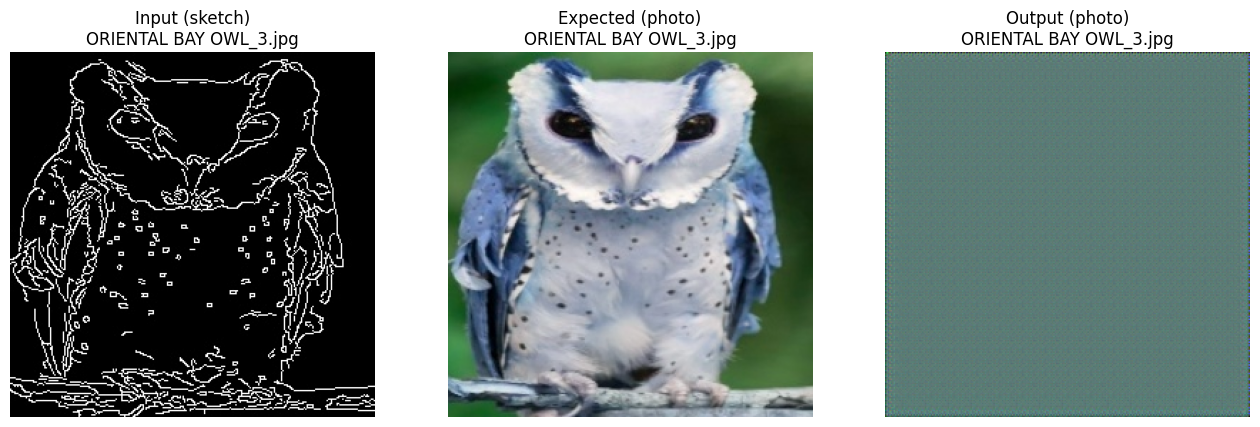

In [105]:
input_image, expected_output, input_filename = next(iter(val_single_loader))
input_image = input_image.cpu().numpy().reshape((256, 256))
expected_output = expected_output.squeeze(0).permute(1,2,0)  # 3xHxW
output_image = run_model_on_image(generator, input_image)

fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(input_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"Input (sketch)\n{input_filename[0]}")

axes[1].imshow(expected_output)
axes[1].axis('off')
axes[1].set_title(f"Expected (photo)\n{input_filename[0]}")

axes[2].imshow(output_image)
axes[2].axis('off')
axes[2].set_title(f"Output (photo)\n{input_filename[0]}")

plt.show()

---

In [95]:
torch.save(generator.state_dict(), "generator.pth")
# To load later:
# generator.load_state_dict(torch.load("generator.pth"))


---

In [4]:
# train_pix2pix.py
import os
from pathlib import Path
import random
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import mlflow

print("Imports complete.")
print(f"PyTorch version: {torch.__version__}, CUDA available: {torch.cuda.is_available()}")

# -----------------------------
# Dataset
# -----------------------------
class Sketch2ImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, image_size=(256,256)):
        self.inputs = sorted(list(Path(input_dir).glob("*.jpg")))
        self.targets = sorted(list(Path(target_dir).glob("*.jpg")))
        self.image_size = image_size
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_img = cv2.imread(str(self.inputs[idx]), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.imread(str(self.targets[idx]))

        input_img = cv2.resize(input_img, self.image_size)
        target_img = cv2.resize(target_img, self.image_size)

        input_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0)
        target_img = torch.tensor(target_img/255.0, dtype=torch.float32).permute(2,0,1)

        return input_img, target_img

# -----------------------------
# Generator (U-Net)
# -----------------------------
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super().__init__()
        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(features, features*2, 4, 2, 1),
                                   nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(features*2, features*4, 4, 2, 1),
                                   nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2))
        self.down4 = nn.Sequential(nn.Conv2d(features*4, features*8, 4, 2, 1),
                                   nn.BatchNorm2d(features*8), nn.LeakyReLU(0.2))
        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(features*8, features*4, 4, 2, 1),
                                 nn.BatchNorm2d(features*4), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(features*8, features*2, 4, 2, 1),
                                 nn.BatchNorm2d(features*2), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(features*4, features, 4, 2, 1),
                                 nn.BatchNorm2d(features), nn.ReLU())
        self.final = nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))
        out = self.final(torch.cat([u3, d1], dim=1))
        return self.tanh(out)

# -----------------------------
# PatchGAN Discriminator
# -----------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=4, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(features, features*2, 4, 2, 1), nn.BatchNorm2d(features*2), nn.LeakyReLU(0.2),
            nn.Conv2d(features*2, features*4, 4, 2, 1), nn.BatchNorm2d(features*4), nn.LeakyReLU(0.2),
            nn.Conv2d(features*4, 1, 4, 1, 1)  # output patch map
        )
    def forward(self, x):
        return self.model(x)

# -----------------------------
# Training Function
# -----------------------------
def train(
    input_dir, target_dir, epochs=10, batch_size=8, lr=2e-4, image_size=(256,256), checkpoint_dir="checkpoints"
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Dataset
    dataset = Sketch2ImageDataset(input_dir, target_dir, image_size=image_size)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Models
    G = UNetGenerator().to(device)
    D = PatchDiscriminator().to(device)

    # Optimizers
    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))

    # Losses
    criterion_l1 = nn.L1Loss()
    criterion_adv = nn.BCEWithLogitsLoss()

    # MLflow
    mlflow.start_run()
    mlflow.log_params({"epochs": epochs, "lr": lr, "batch_size": batch_size, "image_size": image_size})

    for epoch in range(epochs):
        for i, (x, y) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")):
            x, y = x.to(device), y.to(device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            D.zero_grad()
            real_in = torch.cat([x, y], dim=1)
            pred_real = D(real_in)
            loss_D_real = criterion_adv(pred_real, torch.ones_like(pred_real))

            fake = G(x).detach()
            fake_in = torch.cat([x, fake], dim=1)
            pred_fake = D(fake_in)
            loss_D_fake = criterion_adv(pred_fake, torch.zeros_like(pred_fake))

            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            opt_D.step()

            # ---------------------
            # Train Generator
            # ---------------------
            G.zero_grad()
            fake = G(x)
            fake_in = torch.cat([x, fake], dim=1)
            pred_fake = D(fake_in)
            loss_G_adv = criterion_adv(pred_fake, torch.ones_like(pred_fake))
            loss_G_l1 = criterion_l1(fake, y)
            loss_G = loss_G_adv + 100*loss_G_l1  # Pix2Pix weighting
            loss_G.backward()
            opt_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch+1}] Batch {i} Loss_G: {loss_G.item():.4f}, Loss_D: {loss_D.item():.4f}")
                mlflow.log_metric("loss_G", loss_G.item(), step=epoch*len(loader)+i)
                mlflow.log_metric("loss_D", loss_D.item(), step=epoch*len(loader)+i)

        # ---------------------
        # Save checkpoint
        # ---------------------
        torch.save(G.state_dict(), os.path.join(checkpoint_dir, f"G_epoch{epoch+1}.pth"))
        torch.save(D.state_dict(), os.path.join(checkpoint_dir, f"D_epoch{epoch+1}.pth"))

        # Log sample outputs to MLflow
        G.eval()
        with torch.no_grad():
            sample_fake = G(x[:4])
            sample_grid = vutils.make_grid(sample_fake, nrow=2, normalize=True)
            mlflow.log_image(np.transpose((sample_grid.cpu().numpy()*255).astype(np.uint8), (1,2,0)), f"sample_epoch{epoch+1}.png")
        G.train()

    mlflow.end_run()

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    train(
        input_dir="../data_prepared/valid/inputs",
        target_dir="../data_prepared/valid/targets",
        epochs=1,
        batch_size=8,
        lr=1e-3,
        image_size=(256,256)
    )


Imports complete.
PyTorch version: 2.8.0+cu129, CUDA available: True


Epoch 1/1:   1%|          | 3/329 [00:00<00:49,  6.58it/s]

[Epoch 1] Batch 0 Loss_G: 64.1143, Loss_D: 0.7127


Epoch 1/1:  16%|█▌        | 53/329 [00:03<00:19, 13.96it/s]

[Epoch 1] Batch 50 Loss_G: 23.8822, Loss_D: 0.1919


Epoch 1/1:  31%|███▏      | 103/329 [00:07<00:16, 13.83it/s]

[Epoch 1] Batch 100 Loss_G: 26.0070, Loss_D: 0.0669


Epoch 1/1:  47%|████▋     | 153/329 [00:10<00:12, 13.63it/s]

[Epoch 1] Batch 150 Loss_G: 25.1170, Loss_D: 0.0319


Epoch 1/1:  62%|██████▏   | 203/329 [00:14<00:09, 13.09it/s]

[Epoch 1] Batch 200 Loss_G: 24.2472, Loss_D: 0.5667


Epoch 1/1:  77%|███████▋  | 253/329 [00:17<00:05, 13.08it/s]

[Epoch 1] Batch 250 Loss_G: 26.3628, Loss_D: 0.0292


Epoch 1/1:  92%|█████████▏| 303/329 [00:20<00:01, 13.39it/s]

[Epoch 1] Batch 300 Loss_G: 25.7774, Loss_D: 0.0062


Epoch 1/1: 100%|██████████| 329/329 [00:22<00:00, 14.58it/s]


In [3]:
mlflow.end_run()